In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.interpolate as itplt

In [2]:
dat = np.loadtxt("lakeshore.txt")
sort_idx = dat.transpose()[1].argsort()
dat = dat[sort_idx].transpose()

In [3]:
t, v, dvdt = dat

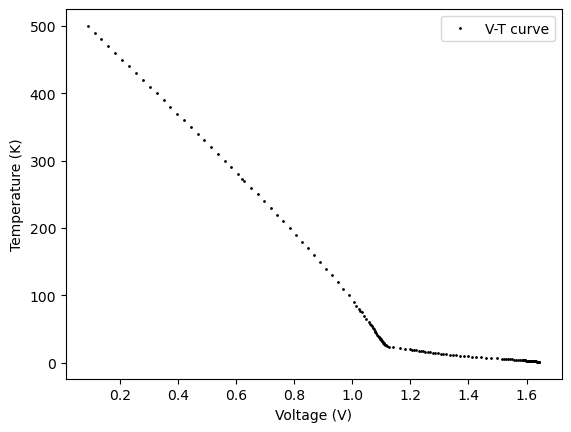

In [4]:
plt.plot(v, t, 'ko', ms = 1, label = "V-T curve")
plt.xlabel("Voltage (V)")
plt.ylabel("Temperature (K)")
plt.legend()

A cubic spline requires two data points and forcing the function to be continuous up to the first derivative.
By default splrep does cubic smooth interpolation on the given (x,y) points and returns knots (points passed through), spline coefficients, and degree (default=3). 

We can pass the spline representation output "spln" to splev for interpolating at a specific point.

In [5]:
# cubic spline fit
spln = itplt.splrep(v, t) 
tt = itplt.splev(v, spln)

# 1. Use Interp vs. splrep to generate estimate

NOTE: The spline went these voltage values, and we CANNOT interpolate at represented (knotted) values to estimate the error
However, we can use the square of the deviation between "cubic spline" and "line interpolation" as our estimate of error. 
Furthermore, we could remove the nearest point in the data from our line interpolation method to reflect how much information is added based on that data point.

Text(0, 0.5, 'T (K)')

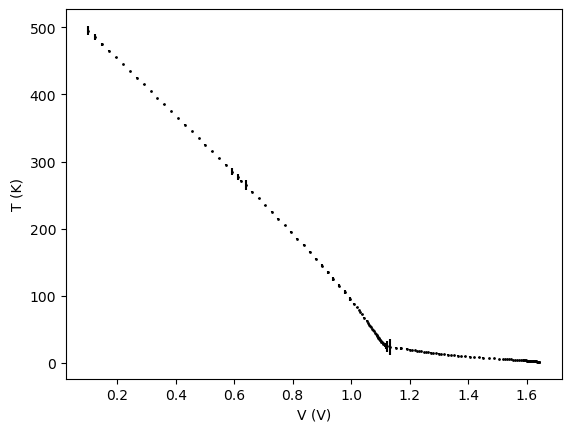

In [6]:
# Creating voltage values in the middle
vlin = v[:-1] + np.diff(v)/2
# linear interpolation at these voltages
tlin = np.interp(vlin , v, t)
# cublic spline at these values
tspl = itplt.splev(vlin, spln)
# use the difference as error
err = np.abs(tspl - tlin)

# NOTE: error is scaled for visualizing
plt.errorbar(vlin, tspl, yerr = err*1e2, fmt = 'ko', ms = 1)
plt.xlabel('V (V)')
plt.ylabel('T (K)')

Scaling the error by factor of 2 for visualizing...

## Now we can generalize this to a function

In [7]:
def lakeshore(V, data):
    sort_idx = data.transpose()[1].argsort()
    data = data[sort_idx].transpose()
    t, v, dvdt = data
    # line interpolation
    tlin = np.interp(V , v, t)
    # cubic spline fit
    spln = itplt.splrep(v, t) 
    tspl = itplt.splev(V, spln)
    err = np.abs(tspl - tlin)
    
    return tspl, err

## Testing

<ErrorbarContainer object of 3 artists>

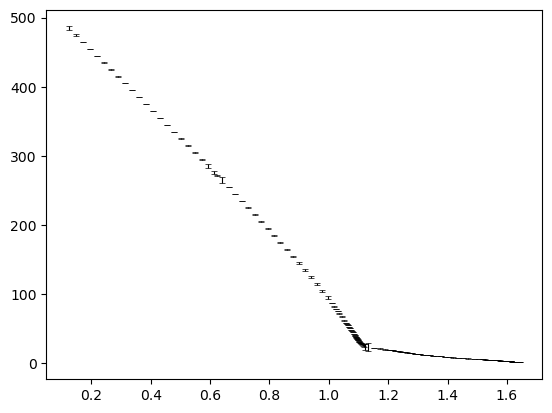

In [8]:
dat = np.loadtxt("lakeshore.txt")
vlin = v[1:-1] + np.diff(v[1:])/2
t, err = lakeshore(vlin, dat)
plt.errorbar(vlin, t, yerr = err*50, fmt = 'ko', ms = 0, elinewidth = .8, capsize = 2, capthick = .5)

WORKS

# 2. Method of "Random Picking"

### Alternatively, we can randomly pick, say, about a third of the data point for spline and interpolate on our interested data points. If we average over enough runs, we can get an idea on how our choice of training set influences out interpolation.

procedure:

    value_array = []
    
    for i in "some iterations":
    
        randomly pick some data, spline
        interpolate on interested points, append to value_array horizontally
        
    take np.std() horizontally on value_array, this value is our estimation 
        
        

In [9]:
dat = np.loadtxt("lakeshore.txt")

In [10]:
def lakeshore2(V, data, runs = 100):
    ## V are the points we want to interpolate on
    v_int = V
    # sorting the data in ascending V
    sort_idx = data.transpose()[1].argsort()
    data = data[sort_idx].transpose()
    t, v, dvdt = data
    
    ## how many runs we want to randomly pick a subset of our data
    runs = runs
    vals = np.zeros((len(v_int), runs))

    for r in np.arange(0, runs):
        ## randomly pick points to remove, except the head and tail
        remove_idx = np.sort(np.random.randint(1, len(v)-1, size=round(len(v)//3), dtype=int))
        ## index of point used for spline
        train_idx = np.delete(np.arange(0,len(v) ,1), remove_idx)
        v_train = np.take(v, train_idx)
        t_train = np.take(t, train_idx)
        # cubic spline fit
        spln = itplt.splrep(v_train, t_train) 
        tt = itplt.splev(v_int, spln)
        ## append to value list horizontally
        vals[:,r] = tt
    ## averaging horizontally to return V and V_std
    mean = np.mean(vals, axis = 1)
    std = np.std(vals, axis = 1, ddof=1)
    
    return mean, std


## Testing

Text(0, 0.5, 'Temperature (T)')

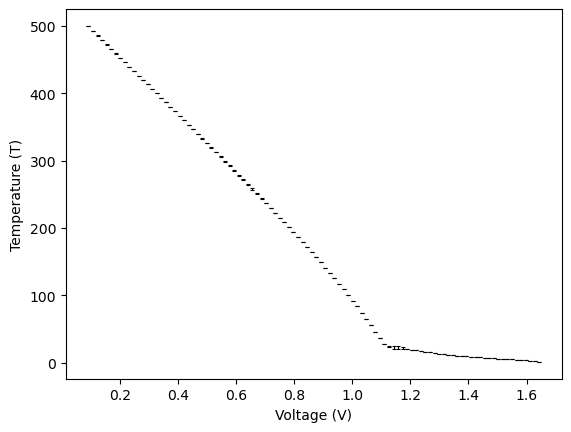

In [11]:
dat = np.loadtxt("lakeshore.txt")
# points over which we interpolate
v_int = np.linspace(v.min(), v.max(), 100)
mean, std = lakeshore2(v_int, dat)
plt.errorbar(v_int, mean, yerr = std*1e1, fmt = 'ko', ms = 0, elinewidth = .8, capsize = 1.5, capthick = .8)
plt.xlabel('Voltage (V)')
plt.ylabel('Temperature (T)')

Plotting the estimated error, scaled by 10